## Goals:

In this notebook, we'll focus on analyzing the data, training different regression models, and comparing their performance using an example based on a real study in which data for a bicycle sharing scheme was collected and used to predict the number of rentals. We'll use the regress_analytics package for the purpose of data and model performance analysis and scikit-learn for model training.

> **Citation**: The data used in this Notebook is derived from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) and is used in accordance with the published [license agreement](https://www.capitalbikeshare.com/data-license-agreement). We are using a simplified version of it from [UC Irvine machine learning repository](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)

## package imports:

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import regress_analytics


## Data Preparation:

### Download data:

In [2]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 
  
# data (as pandas dataframes) 
X = bike_sharing.data.features.copy(deep=True) 
y = bike_sharing.data.targets.copy(deep=True)  
  
# variable information 
print(bike_sharing.variables) 

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

### Data Peprocessing:

In [3]:
# change target name to num_rentals
y.columns = ['num_rentals']
# concat features and targets for preprocessing
bike_data = pd.concat([X,y], axis=1)

# getting average of features over different hours of the day
# and summing num_rentals
grouped_data = bike_data.groupby("dteday")
bike_data_constant_features =grouped_data[["season", "yr", "mnth", "holiday", "weekday", "workingday"]].first().reset_index()
bike_data_mode_features = grouped_data[["weathersit"]].apply(lambda grp: grp.mode().iloc[0]).reset_index(drop=True)
bike_data_mean_features = grouped_data[["temp","atemp", "hum", "windspeed"]].mean().reset_index(drop=True)
bike_data_target = grouped_data[["num_rentals"]].sum().reset_index(drop = True)

bike_data = pd.concat([bike_data_constant_features, bike_data_mode_features, bike_data_mean_features, bike_data_target], axis=1)

# Convert dates to a categorical feature spanning from 1 to 31
bike_data.loc[:,'day'] = pd.DatetimeIndex(bike_data['dteday']).day
bike_data.head(32)


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,num_rentals,day
0,2011-01-01,1,0,1,0,6,0,1,0.344167,0.363625,0.805833,0.160446,985,1
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,2
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,3
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,4
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,5
5,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,1606,6
6,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,1510,7
7,2011-01-08,1,0,1,0,6,0,1,0.165000,0.162254,0.535833,0.266804,959,8
8,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,822,9
9,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,1321,10


### Data Splitting:

There are a lot of different methods that can be used for splitting data to assure a fair split. For the purpose of this example, we are not going into details of these methods and use the simple train_test_split function from Scikit-learn package

In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(bike_data, test_size=0.30, random_state=0)

## Data Analysis:

### Statistics:

OK, let's start our analysis with some statistics from the data

In [5]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
bike_data[numeric_features + ['num_rentals']].describe()

,temp,atemp,hum,windspeed,num_rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,4504.348837
std,0.183051,0.162961,0.142429,0.077498,1937.211452
min,0.059130,0.079070,0.000000,0.022392,22.000000
25%,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,0.655417,0.608602,0.730208,0.233215,5956.000000
max,0.861667,0.840896,0.972500,0.507463,8714.000000


### Data Visualization:

Now let's use regress_analytics package to visualize the distributions of the train and test data sets to understand
1) Distribution of each feature
2) whether the data splitting process was suucessful in generating dataset with similar distributions

First let's check out the distribution of the data:

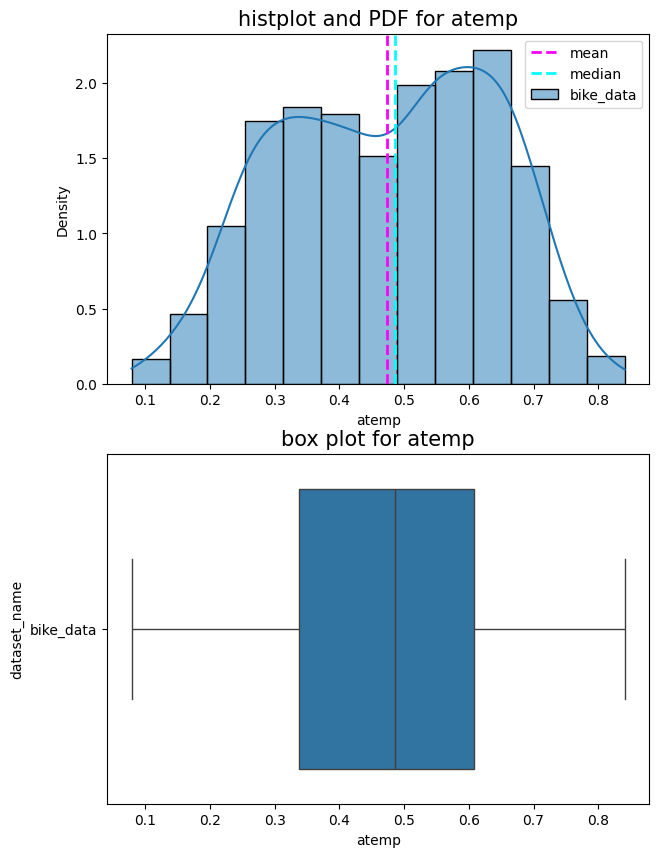

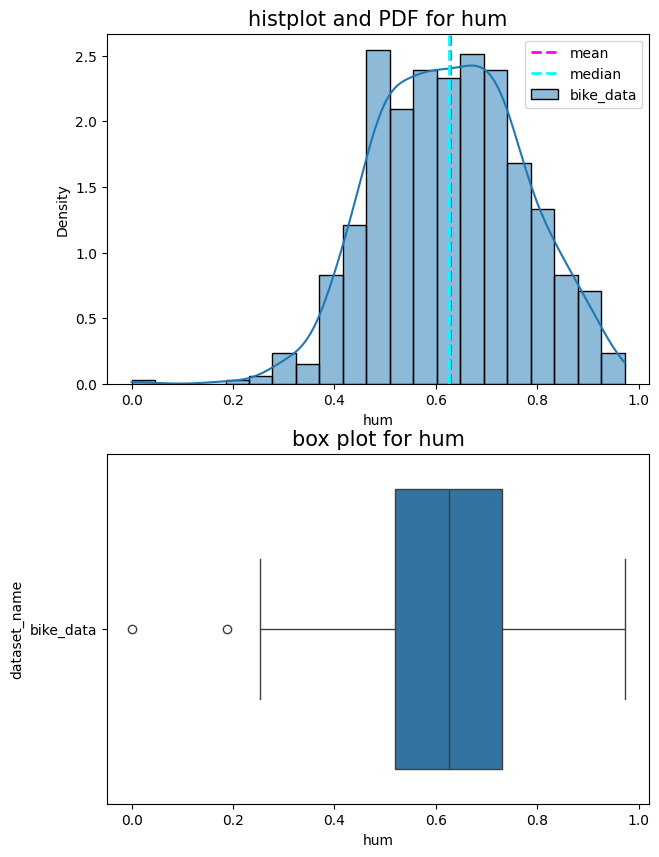

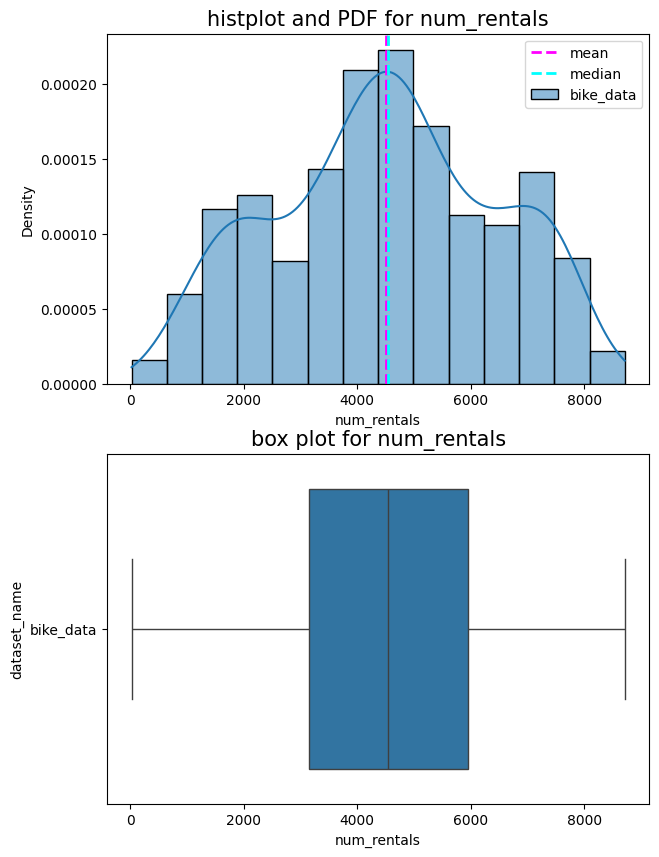

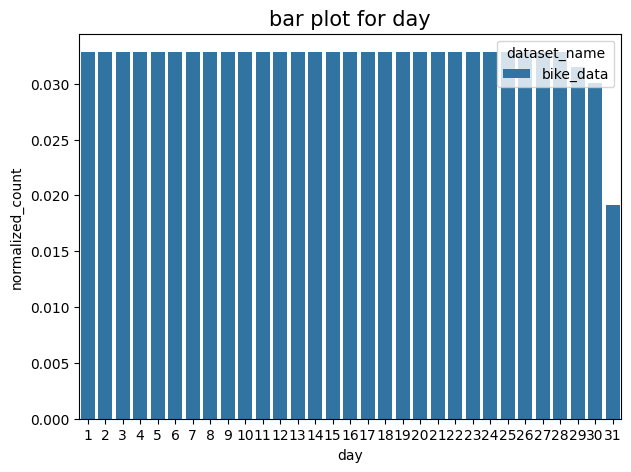

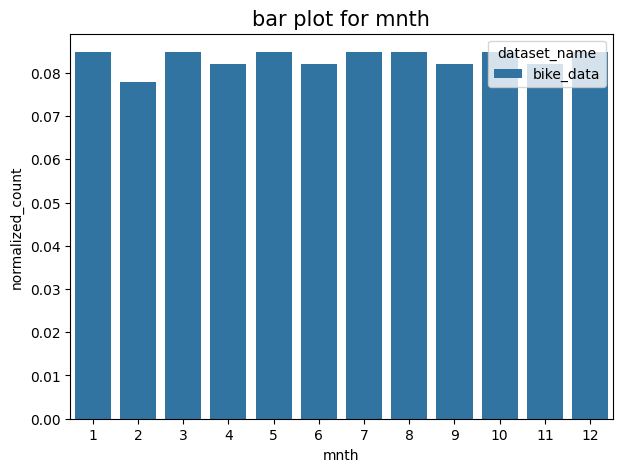

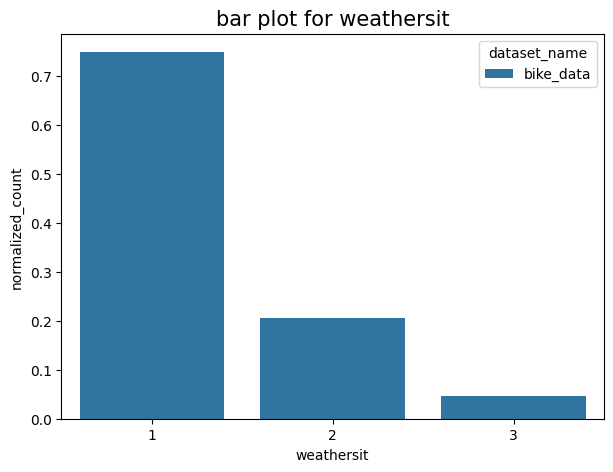

In [6]:
from regress_analytics.EDA import DataDist

DataDist().plot(
    data_sets = [bike_data],
    data_set_names= ["bike_data"],
    numerical_feature_names= ['atemp', 'hum', 'num_rentals'],
    categorical_feature_names =['day','mnth', 'weathersit'],
    figsize = (7, 10),
)

Next let's compare the training and test set distributions across a few of the features and the target to make sure that our data is splitted fairly.

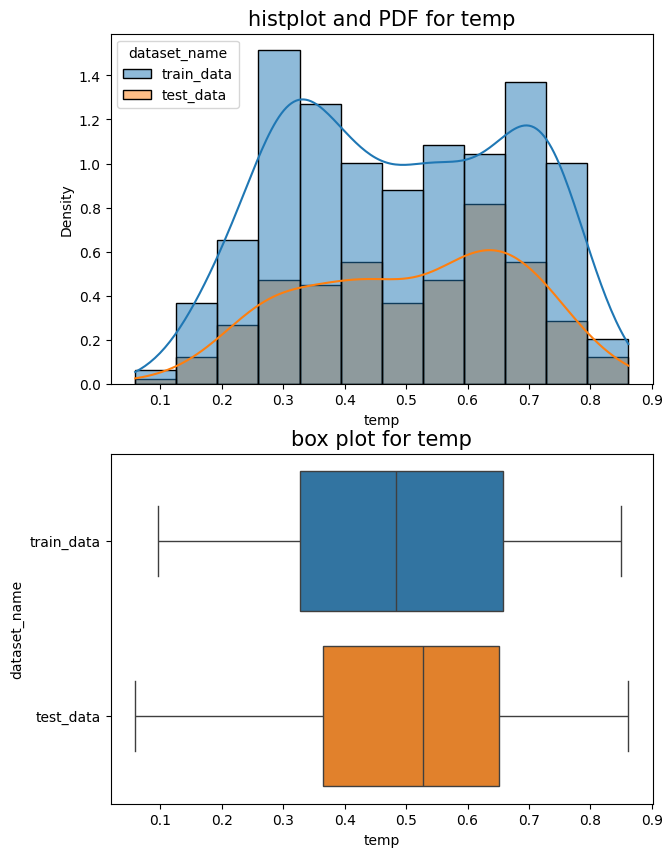

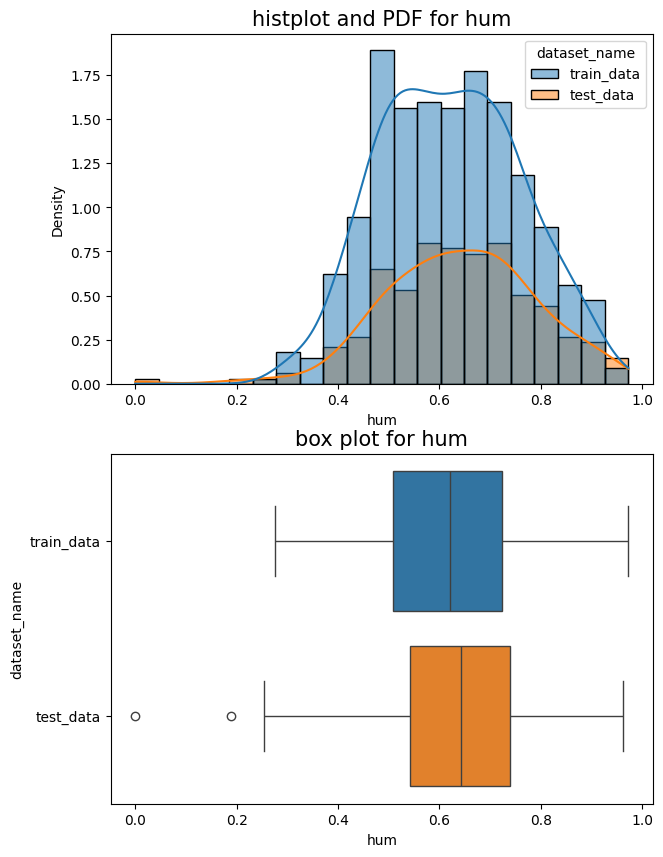

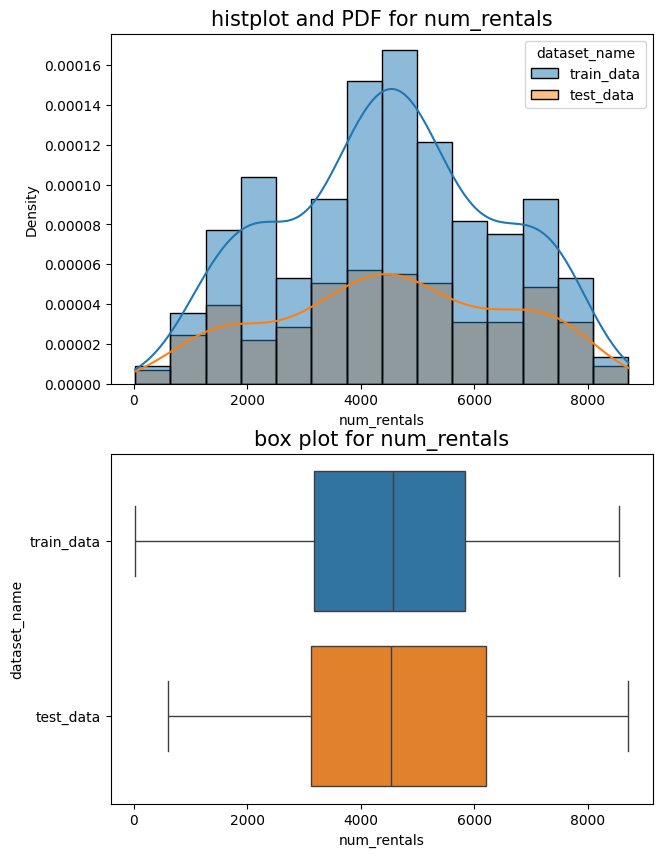

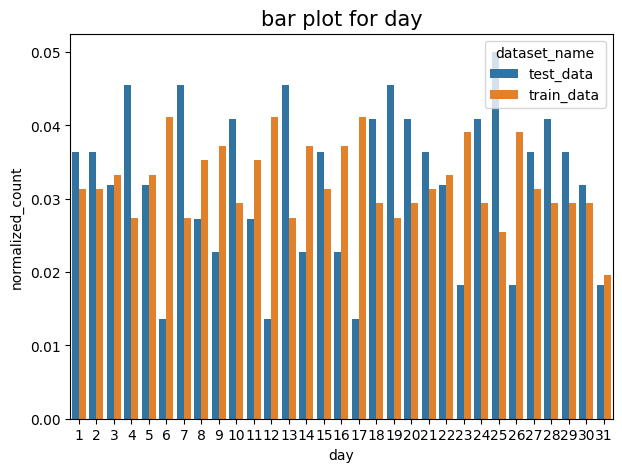

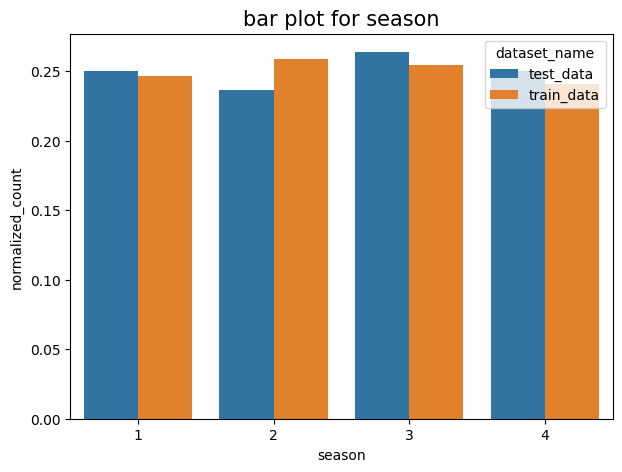

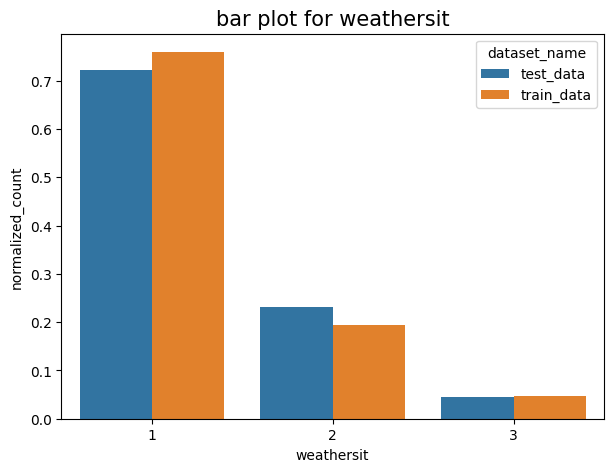

In [7]:
DataDist().plot(
    data_sets = [train_data, test_data],
    data_set_names= ["train_data", "test_data"],
    numerical_feature_names= ['temp', 'hum', 'num_rentals'],
    categorical_feature_names =['day', 'season', 'weathersit'],
    figsize = (7, 10),
)

## Train a Regression Model

Now it's time to use the data to train a regression model that uses the features we've identified as potentially predictive to predict the **num_rentals** label. For that, we'll use three models:
1. Linear regression
2. Decision tree
3. Gradient boosting
Although linear regression is not a good option for the cases where we have both numerical and categorical feature, we are using it for comparison and to show how insights provided by regress_analytics can lead to a better understanding of the models and how they work.

In [8]:
feature_names = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed','day'
    ]
target_name = 'num_rentals'

X_train = train_data[feature_names]
y_train = train_data[target_name]

X_test = test_data[feature_names]
y_test = test_data[target_name]

### Linear regression model:

In [9]:
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

### Evaluate the Trained Model

Now that we've trained the model, we can use it to predict rental counts for the samples we held back in our test dataset. Then we can compare these predictions to the actual label values to see how well the model is working. Plotting predictions agains ground truth labels is an effective way of evaluating your model. An idea model is one that generates points that are very close to the unity line.

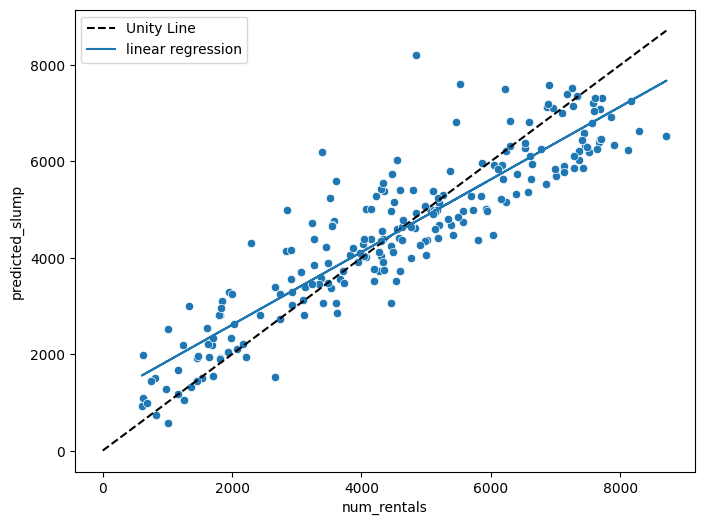

In [10]:
from regress_analytics.model_performance_analysis import PredsVsTrue

linear_regression_predictions = linear_regression_model.predict(X_test)
PredsVsTrue().plot(y_true = y_test,
        y_pred = [linear_regression_predictions],
        model_names = ["linear regression"],
        figsize=(8, 6),)

There's a definite diagonal trend, and the intersections of the predicted and actual values are generally following the path of the trend line; but there's a fair amount of difference between the ideal unity line and the results. This variance represents the *residuals* of the model - in other words, the difference between the predicted and the actual value of the validation label.

We can quantify the residuals using the following five errors

1. **Mean Absolute Error (MAE)**
2. **Mean Percentage Error (MAPE)**
3. **Mean Square Error (MSE)**
4. **Root Mean Square Error (RMSE)**
5. **Coefficient of Determination (usually known as *R-squared* or R<sup>2</sup>)**

In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, linear_regression_predictions)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, linear_regression_predictions)
print("MAPE:", mape)

mse = mean_squared_error(y_test, linear_regression_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, linear_regression_predictions)
print("R2:", r2)

MAE: 667.3147699849973
MAPE: 0.19715890591930835
MSE: 765147.1469326887
RMSE: 874.7268984847149
R2: 0.8146046479250251


### Decision Tree model

A tree-based approach in which the features in the dataset are examined in a series of evaluations is much better suited to our data.
It's easiest to see how this works with an example. Let's train a Decision Tree regression. After training the model, we can see the text representation of the tree!

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Train the model
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# text representation of the tree
tree = export_text(dt_model)
print(tree)

|--- feature_7 <= 0.46
|   |--- feature_1 <= 0.50
|   |   |--- feature_2 <= 3.50
|   |   |   |--- feature_2 <= 1.50
|   |   |   |   |--- feature_9 <= 0.63
|   |   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |   |--- feature_8 <= 0.21
|   |   |   |   |   |   |   |--- feature_4 <= 3.50
|   |   |   |   |   |   |   |   |--- feature_6 <= 1.50
|   |   |   |   |   |   |   |   |   |--- value: [986.00]
|   |   |   |   |   |   |   |   |--- feature_6 >  1.50
|   |   |   |   |   |   |   |   |   |--- value: [1000.00]
|   |   |   |   |   |   |   |--- feature_4 >  3.50
|   |   |   |   |   |   |   |   |--- value: [959.00]
|   |   |   |   |   |   |--- feature_8 >  0.21
|   |   |   |   |   |   |   |--- value: [1204.00]
|   |   |   |   |   |--- feature_5 >  0.50
|   |   |   |   |   |   |--- feature_8 <= 0.23
|   |   |   |   |   |   |   |--- feature_7 <= 0.18
|   |   |   |   |   |   |   |   |--- feature_10 <= 0.30
|   |   |   |   |   |   |   |   |   |--- feature_11 <= 11.50
|   |   |   |   |   

So now we have a tree-based model; but is it any good? Let's evaluate it with the test data.

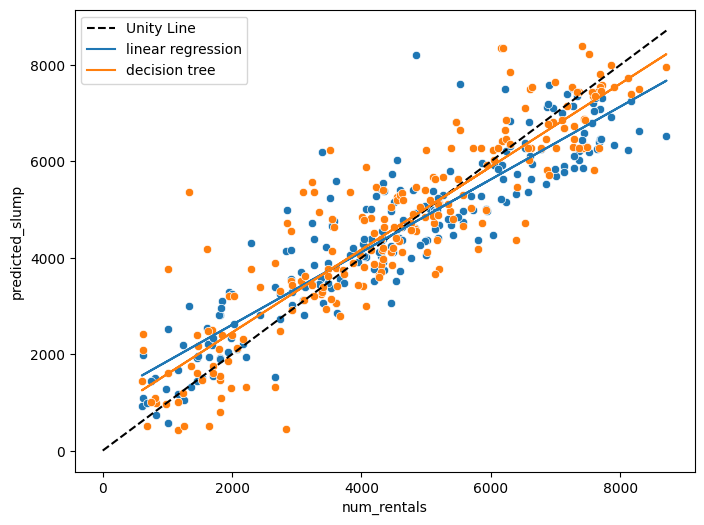

MAE: 654.7590909090909
MAPE: 0.22570339175106807
MSE: 818790.4227272727
RMSE: 904.8703900157595
R2: 0.801606868292362


In [13]:
# Evaluate the model using the test data
dt_predictions = dt_model.predict(X_test)

PredsVsTrue().plot(y_true = y_test,
        y_pred = [linear_regression_predictions, dt_predictions],
        model_names = ["linear regression", "decision tree"],
        figsize=(8, 6),)

mae = mean_absolute_error(y_test, dt_predictions)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, dt_predictions)
print("MAPE:", mape)

mse = mean_squared_error(y_test, dt_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, dt_predictions)
print("R2:", r2)

We can extract very valueable insights from the charts and scores above. It is interesting to see that MAE, MAPE and our charts suggest that the decision tree performs better. However, RMSE suggests that linear regression is performing better. MSE and RMSE are generally more prone to outliers and by looking at the charts we can clearly see that although decision tree's generall trend is better than linear regression, there are some samples which have a predicted value that is far from the true label value.

### Gradient boosting model

Now, let's train a boosting ensemble algorithm. We'll use a Gradient Boosting estimator, which like a Random Forest algorithm builds multiple trees, but instead of building them all independently and taking the average result, each tree is built on the outputs of the previous one in an attempt to incrementally reduce the loss in the model.

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

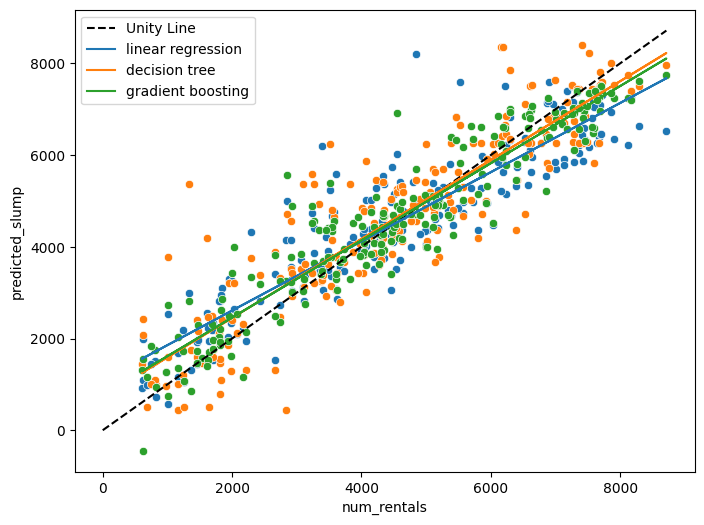

MAE: 515.0829203233219
MAPE: 0.17564721732568053
MSE: 471078.35156326863
RMSE: 686.3514781533355
R2: 0.8858575932837477


In [15]:
# Evaluate the model using the test data
gb_predictions = gb_model.predict(X_test)

PredsVsTrue().plot(y_true = y_test,
        y_pred = [linear_regression_predictions, dt_predictions, gb_predictions],
        model_names = ["linear regression", "decision tree", "gradient boosting"],
        figsize=(8, 6),)

mae = mean_absolute_error(y_test, gb_predictions)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, gb_predictions)
print("MAPE:", mape)

mse = mean_squared_error(y_test, gb_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, gb_predictions)
print("R2:", r2)

It is clear that the genral trend in the true_vs_preds chart above is very similar for decision tree and gradient boosting. However, the number of samples that have considerably different predictions compared to the true values is decreased. Considering all the information we've got from the charts and the scores, we can conclude that the gradient boosting model is the winner.

## Compare models:

Earlier we saw preds_vs_true plot that allows us to gain better understanding of how the models work and allow us to go beyond just scores.  Now let's take a look at another informative plot that the regress_analytics package provides. It is called **bin analyzer**. It allows you to divide any numerical feature or target into bins (equal width or equal frequency) and then see how mean or median of the target changes within those bins. It is a very powerful tool which allows us to detect areas of weakness in our models and give us guidance regarding the next steps we need to take to improve the performance of our model.

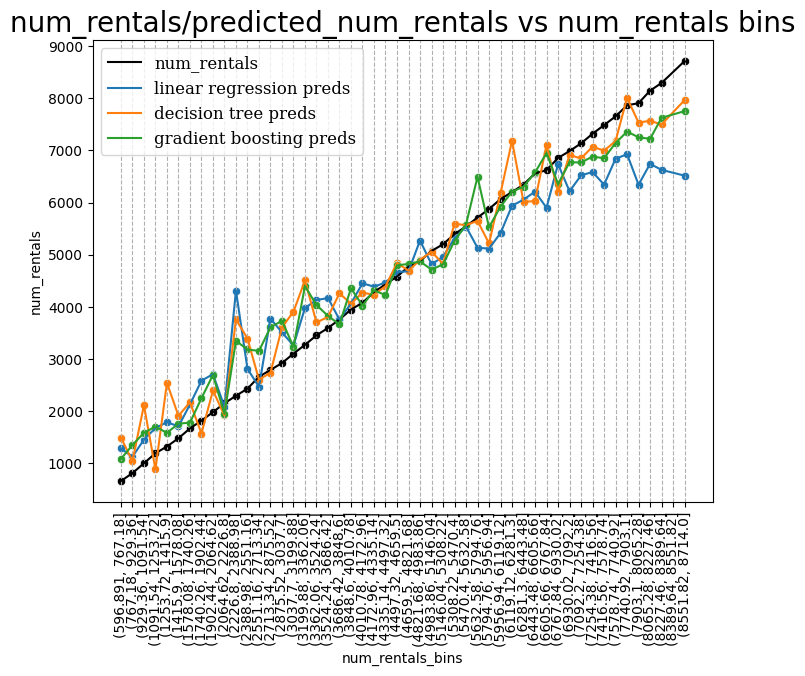

In [16]:
from regress_analytics.model_performance_analysis import BinAnalyzer

agg_data_based_on_bins_temp = BinAnalyzer().plot(
        data =  test_data,
        feature_col_name=  "num_rentals",
        output_col_name = "num_rentals",
        models=  [linear_regression_model, dt_model, gb_model],
        model_names = ["linear regression", "decision tree", "gradient boosting"],
        model_features = [['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                          ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                          ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day']],
        multi_output_model = [False,False, False],
        binning_method = "equal_width",
        num_bins = 50,
        aggregate_func="mean",
        index_to_use = None,
        figsize= (8, 6))

In this example we can see how well (or not!) each model is performing within different bins of num_rentals compared to other models. Gradient boosting model seems to have less variance in predictions across different bins. However, There are two things that draw our attention:

1. The sudden spike in the bin (2226.8, 2388.98]
2. under prediction of rental numbers for values larger than ~7092

If we wanted to take actions based on our error analysis these two would be good candidates for deeper analysis. We'll leave it for another notebook where we try to delve deeper and address performance issues.

Let's now look at a similar chart but for a feature like temp:

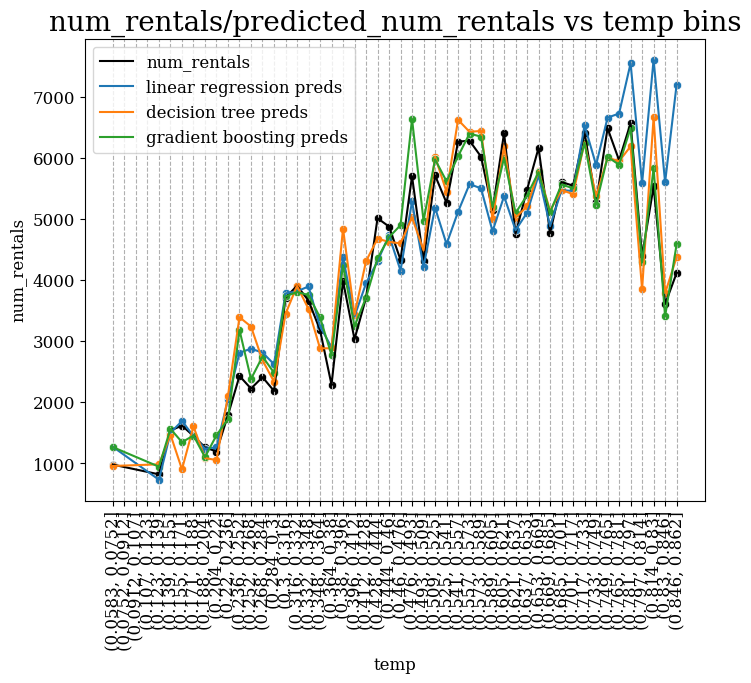

In [17]:
_ = BinAnalyzer().plot(
        data = test_data,
        feature_col_name=  "temp",
        output_col_name = "num_rentals",
        models=  [linear_regression_model, dt_model, gb_model],
        model_names = ["linear regression", "decision tree", "gradient boosting"],
        model_features = [['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                          ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                          ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day']],
        multi_output_model = [False,False, False],
        binning_method = "equal_width",
        num_bins = 50,
        aggregate_func="mean",
        index_to_use = None,
        figsize= (8, 6))

The equivalent of Bin Analyzer for categorical features is called category analyzer and you can see a smaple for the "season" feature. We can see how our model is doing for each category of the feature. For example, for this specific feature (season) we can see that even Gradient boosting model is having a hard time to capture all the varience when season is 4 (Fall). This can be explained with the fact that in Fall the weather is more unpredictable and you might get days with very pleasant conditions and as a results, see higher bike renting numbers.

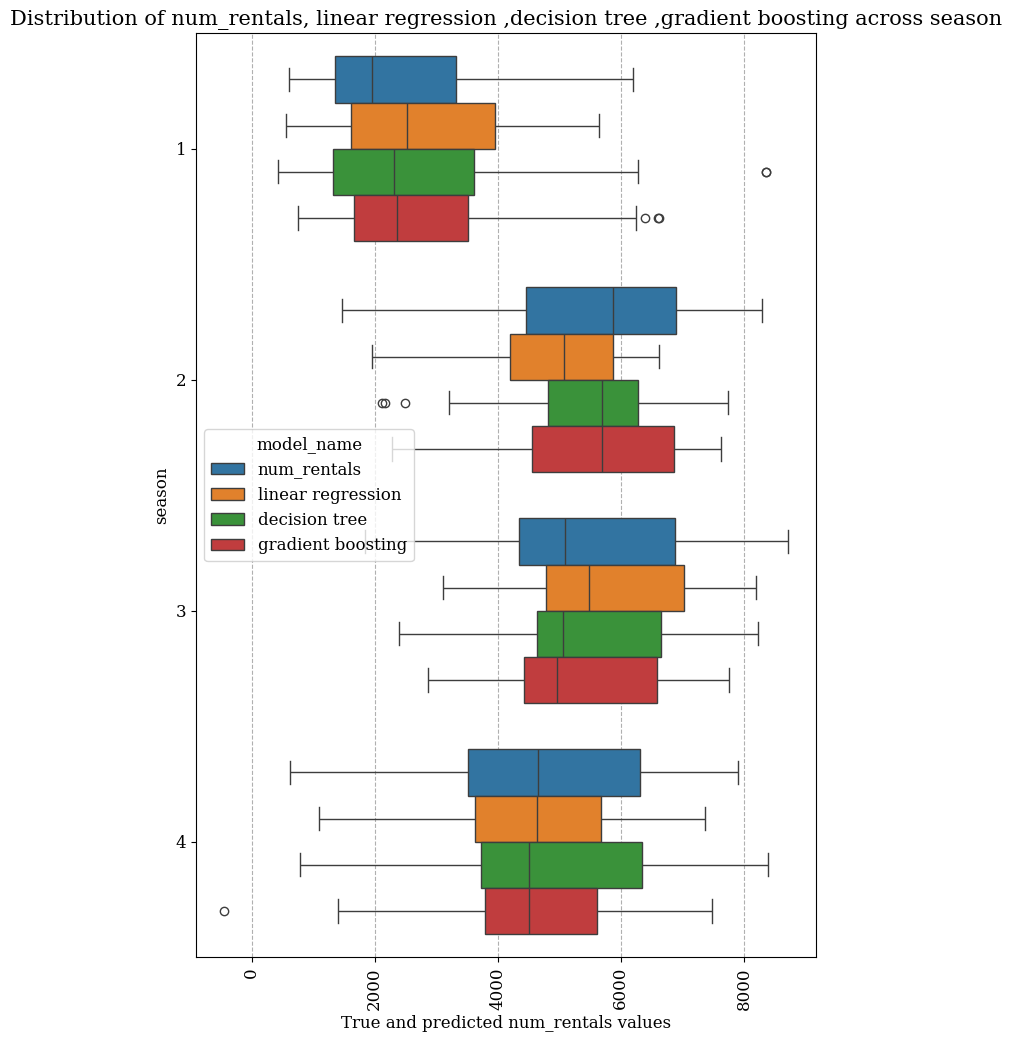

In [18]:
from regress_analytics.model_performance_analysis import CategoryAnalyzer

CategoryAnalyzer().plot(
    data = test_data,
    feature_col_name = "season",
    output_col_name = 'num_rentals',
    models=  [linear_regression_model, dt_model, gb_model],
    model_names = ["linear regression", "decision tree", "gradient boosting"],
    model_features = [['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                        ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                        ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day']],
    multi_output_model=  [False, False, False],
    index_to_use = None,
    figsize = (8, 12)
)


Before we wrap up this notebook, let's look at another interesting test called **Sensitivity test** that you can perform to see how sensitive your model is to the variations in each feature. When performing this test for a feature, the function keeps all other features in your data constant and changes the values of that specific feature by gradually increasing it from acceptable lower range to acceptable higher range and gets the predictions of your model for all samples in your data and altimately calculates the average of the predictions. This will show you how your predictions change as the values of your feature change and how sensitive your model is to the variations of a feature. If you model is too sensitive or not sensitive at all, it means that you should work more on that feature!

Running sensitivity test for linear regression
Running sensitivity test for decision tree
Running sensitivity test for gradient boosting


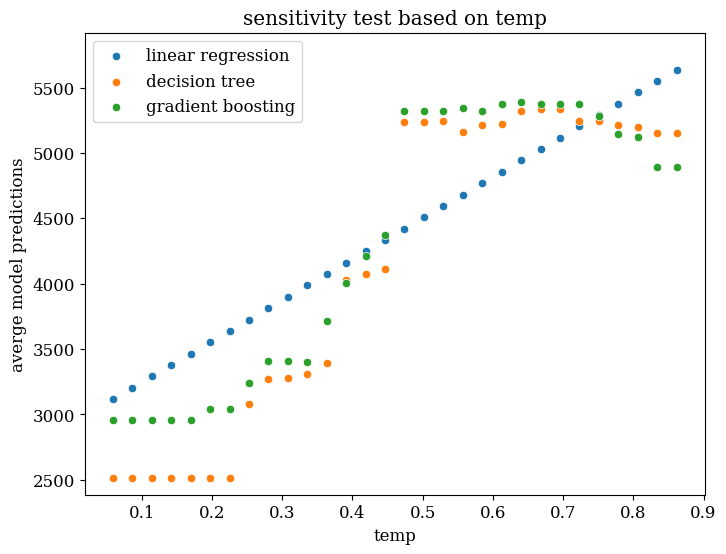

In [19]:
from regress_analytics.model_performance_analysis import SensitivityTest

SensitivityTest().plot(
        features =test_data,
        feature_col_name = "temp",
        models=  [linear_regression_model, dt_model, gb_model],
        model_names = ["linear regression", "decision tree", "gradient boosting"],
        model_features = [['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                            ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
                            ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day']],
        multi_output_model= [False, False, False],
        acceptable_feature_range = None,
        num_samples= 30,
        index_to_use = None,
        figsize = (8, 6),
    )

The chart above beautifully illustrates the underlying characteristics of the models used for this problem. We can see that the relationship between num_rentals and temp is linear in linear regression. On the other hand, for tree-based algorithms, it appears more like steps (resulting from the conditions the tree is trained on)